<a href="https://colab.research.google.com/github/trappertwo/rPPG_experiments/blob/main/SwinIR_demo_on_rPPG_compressed_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Preparations
Before start, make sure that you choose
* Runtime Type = Python 3
* Hardware Accelerator = GPU
* Broswer != Firefox (cannot upload images in step 2)

in the **Runtime** menu -> **Change runtime type**

Then, we clone the repository, set up the envrironment, and download the pre-trained model.

In [1]:
!python --version
# Imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

!pip install -q mediapy
import mediapy as media

Python 3.11.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.0 MB/s eta 0:00:00


In [2]:
# Download SwinIR pretrained models
!rm -r SwinIR
# Clone SwinIR
!git clone https://github.com/JingyunLiang/SwinIR.git
!pip install timm

# Download the pre-trained models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth -P experiments/pretrained_models
!wget https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/005_colorDN_DFWB_s128w8_SwinIR-M_noise15.pth -P experiments/pretrained_models

rm: cannot remove 'SwinIR': No such file or directory
Cloning into 'SwinIR'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 333 (delta 6), reused 2 (delta 2), pack-reused 323 (from 2)
Receiving objects: 100% (333/333), 29.84 MiB | 25.00 MiB/s, done.
Resolving deltas: 100% (119/119), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/

In [3]:
### UBFC-rPPG dataset in drive folder
from google.colab import drive

drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_2/subject1/vid.avi' # @param {type: "string"}
!ls -l $filepath

Mounted at /content/drive
ls: cannot access '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_2/subject1/vid.avi': No such file or directory


In [46]:
video = media.read_video(filepath)

RuntimeError: Video file '/content/drive/MyDrive/research_project/data/UBFC-rPPG/DATASET_2/subject1/vid.avi' is not found.

In [ ]:
# Compress the video with default settings (H.264 codec)
COMPRESSION_BIT_RATES = {500_000, 200_000, 100_000}

compressed_data = {}
i = 0
for bps in COMPRESSION_BIT_RATES:
    compressed_data[bps] = media.compress_video(video, bps=bps, fps=30)
    print(len(compressed_data[bps]))

3242186
1303890
658209


In [ ]:
# Save the compressed video to a file
with open('/tmp/subject1_500_000.mp4', 'wb') as f:
    f.write(compressed_data[500_000])
with open('/tmp/subject1_200_000.mp4', 'wb') as f:
    f.write(compressed_data[200_000])
with open('/tmp/subject1_100_000.mp4', 'wb') as f:
    f.write(compressed_data[100_000])

In [ ]:
# Show original and compressed video side-by-side
compressed_video = media.read_video('/tmp/subject1_500_000.mp4')
compressed_video_2 = media.read_video('/tmp/subject1_200_000.mp4')
compressed_video_3 = media.read_video('/tmp/subject1_100_000.mp4')
videos = {'Original': video[:10], 'Compressed_200_000': compressed_video_2[:10], 'Compressed_100_000': compressed_video_3[:10], 'Compressed_500_000': compressed_video[:10] }
media.show_videos(videos, fps=30)

In [4]:
import cv2
import os
import shutil

"""
This script converts a video into individual frames and saves them to a specified directory.
Only a subset of frames is saved based on a defined interval to match the desired frame rate for further processing.
"""

# Path to the video file
video_path = '/content/drive/MyDrive/DATASETS/DATASET_100_1_train/subject3/vid.mp4' # @param {type: "string"}
#!ls -l video_path
# Directory to save the frames
output_folder = '/tmp/output_dir_100' # @param {type: "string"}

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

# Load the video
cap = cv2.VideoCapture(video_path)

# Get the frame rate of the video
fps = cap.get(cv2.CAP_PROP_FPS)
frames_per_second = 30
interval = int(fps / frames_per_second)
print(f"Frames per second: {fps}")
print(f"Interval: {interval}")
frame_count = 0
saved_frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Save frame if it's in the interval
    if frame_count % interval == 0:
        frame_filename = os.path.join(output_folder, f'frame_{saved_frame_count:04d}.jpg')
        # Save the frame as a JPG image
        cv2.imwrite(frame_filename, frame)
        saved_frame_count += 1

    frame_count += 1

cap.release()
print(f'Extracted {saved_frame_count} frames to {output_folder}')

Frames per second: 30.0
Interval: 1
Extracted 1801 frames to /tmp/output_dir_100


In [5]:
!ls -l $output_folder

total 93540
-rw-r--r-- 1 root root 37004 Jul 11 02:13 frame_0000.jpg
-rw-r--r-- 1 root root 38760 Jul 11 02:13 frame_0001.jpg
-rw-r--r-- 1 root root 38717 Jul 11 02:13 frame_0002.jpg
-rw-r--r-- 1 root root 38786 Jul 11 02:13 frame_0003.jpg
-rw-r--r-- 1 root root 38357 Jul 11 02:13 frame_0004.jpg
-rw-r--r-- 1 root root 41505 Jul 11 02:13 frame_0005.jpg
-rw-r--r-- 1 root root 41900 Jul 11 02:13 frame_0006.jpg
-rw-r--r-- 1 root root 42419 Jul 11 02:13 frame_0007.jpg
-rw-r--r-- 1 root root 41780 Jul 11 02:13 frame_0008.jpg
-rw-r--r-- 1 root root 46395 Jul 11 02:13 frame_0009.jpg
-rw-r--r-- 1 root root 46807 Jul 11 02:13 frame_0010.jpg
-rw-r--r-- 1 root root 48050 Jul 11 02:13 frame_0011.jpg
-rw-r--r-- 1 root root 47832 Jul 11 02:13 frame_0012.jpg
-rw-r--r-- 1 root root 49333 Jul 11 02:13 frame_0013.jpg
-rw-r--r-- 1 root root 49273 Jul 11 02:13 frame_0014.jpg
-rw-r--r-- 1 root root 49788 Jul 11 02:13 frame_0015.jpg
-rw-r--r-- 1 root root 49063 Jul 11 02:13 frame_0016.jpg
-rw-r--r-- 1 root r

In [9]:
# Copy a frame to the input folder
!mkdir testsets
!mkdir testsets/LIVE1
import os
import cv2
import shutil
import matplotlib.pyplot as plt

for frame_name in os.listdir(output_folder):
  file_path = os.path.join(output_folder, frame_name)
  # Check if the file is a frame image
  if os.path.isfile(file_path) and frame_name.startswith('frame_') and frame_name.endswith('.jpg'):
    img = cv2.imread(file_path) # Move this line before it's used
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    shutil.move(file_path, os.path.join('testsets/LIVE1/', frame_name))

mkdir: cannot create directory ‘testsets’: File exists
mkdir: cannot create directory ‘testsets/LIVE1’: File exists


# 3. Inference







In [10]:
# Run inference using SwinIR transformer model for color JPEG compression artifact reduction
!python SwinIR/main_test_swinir.py --task color_jpeg_car --jpeg 10 --model_path model_zoo/swinir/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth --folder_gt testsets/LIVE1
# Run inference using SwinIR transformer model for color denoising

#!python SwinIR/main_test_swinir.py --task color_dn --noise 15 --model_path model_zoo/swinir/005_colorDN_DFWB_s128w8_SwinIR-M_noise15.pth --folder_gt testsets/LIVE1

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
downloading model model_zoo/swinir/006_colorCAR_DFWB_s126w7_SwinIR-M_jpeg10.pth
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Testing 0 frame_0000           - PSNR: 36.89 dB; SSIM: 0.9724; PSNRB: 37.11 dB;PSNR_Y: 42.02 dB; SSIM_Y: 0.9828; PSNRB_Y: 42.02 dB.
Testing 1 frame_0001           - PSNR: 36.99 dB; SSIM: 0.9724; PSNRB: 37.21 dB;PSNR_Y: 41.96 dB; SSIM_Y: 0.9826; PSNRB_Y: 41.96 dB.
Testing 2 frame_0002           - PSNR: 36.79 dB; SSIM: 0.9724; 

In [14]:
!ls -l results/swinir_color_jpeg_car_jpeg10

#!ls -l results/swinir_color_dn_noise15

total 333760
-rw-r--r-- 1 root root 188297 Jul 11 02:15 frame_0000_SwinIR.png
-rw-r--r-- 1 root root 186844 Jul 11 02:16 frame_0001_SwinIR.png
-rw-r--r-- 1 root root 186587 Jul 11 02:16 frame_0002_SwinIR.png
-rw-r--r-- 1 root root 186685 Jul 11 02:16 frame_0003_SwinIR.png
-rw-r--r-- 1 root root 187134 Jul 11 02:16 frame_0004_SwinIR.png
-rw-r--r-- 1 root root 187438 Jul 11 02:16 frame_0005_SwinIR.png
-rw-r--r-- 1 root root 188121 Jul 11 02:16 frame_0006_SwinIR.png
-rw-r--r-- 1 root root 186023 Jul 11 02:16 frame_0007_SwinIR.png
-rw-r--r-- 1 root root 187387 Jul 11 02:16 frame_0008_SwinIR.png
-rw-r--r-- 1 root root 187795 Jul 11 02:17 frame_0009_SwinIR.png
-rw-r--r-- 1 root root 186965 Jul 11 02:17 frame_0010_SwinIR.png
-rw-r--r-- 1 root root 187673 Jul 11 02:17 frame_0011_SwinIR.png
-rw-r--r-- 1 root root 188470 Jul 11 02:17 frame_0012_SwinIR.png
-rw-r--r-- 1 root root 187348 Jul 11 02:17 frame_0013_SwinIR.png
-rw-r--r-- 1 root root 188190 Jul 11 02:17 frame_0014_SwinIR.png
-rw-r--r-- 1

Original,SwinIR CAR

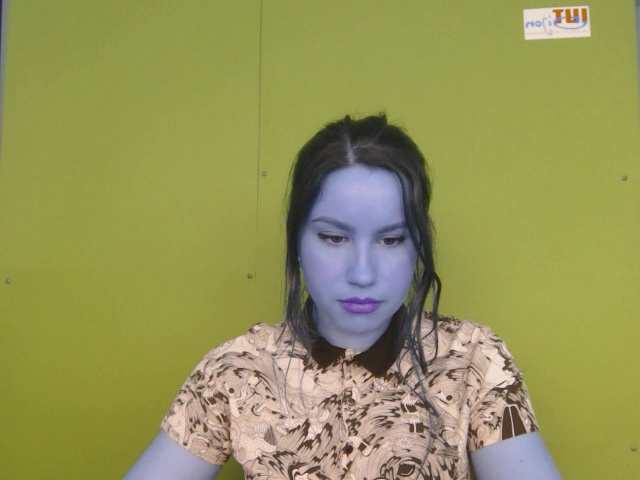
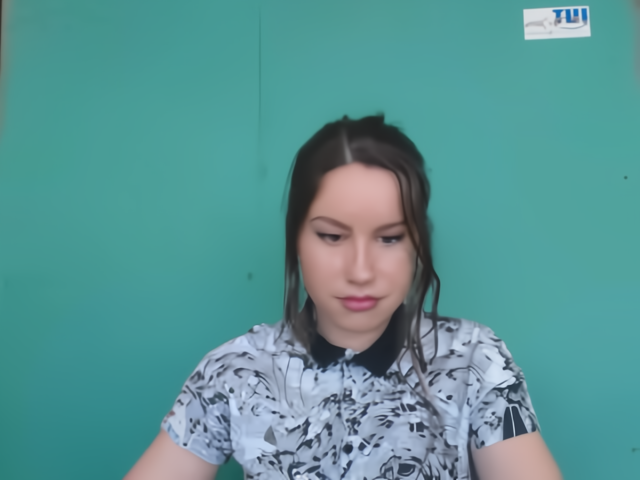

In [22]:
img2 = cv2.imread('results/swinir_color_jpeg_car_jpeg10/frame_0000_SwinIR.png', cv2.IMREAD_UNCHANGED)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
#plt.imshow(img2)
#img3 = cv2.imread('results/swinir_color_dn_noise15/frame_0000_SwinIR.png', cv2.IMREAD_UNCHANGED)
#img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
images = {'Original': img, 'SwinIR CAR': img2}
media.show_images(images)

In [15]:
#Combine all frames into one video:

image_folder = 'results/swinir_color_jpeg_car_jpeg10'
video_name = 'restored_subject3.mp4' # Change file extension to .mp4
images = [img for img in os.listdir(image_folder)]
images.sort() # Ensure images are in correct order
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Use 'mp4v' codec for MP4
video = cv2.VideoWriter(video_name, fourcc, 30, (width,height)) # Use the correct frame rate

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

#cv2.destroyAllWindows()
video.release()

In [54]:
import cv2

# Path to the original video file from cell V9-GWIaabO0K
video_path = '/content/drive/MyDrive/DATASETS/DATASET_100_1_train/subject1/vid.mp4'

cap = cv2.VideoCapture(video_path)
original_fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

print(f"Original video frame rate: {original_fps}")

Original video frame rate: 30.0


In [57]:
!mkdir /content/drive/MyDrive/DATASETS/subject1_restored
!cp -R results/swinir_color_jpeg_car_jpeg10/* /content/drive/MyDrive/DATASETS/subject1_restored/

mkdir: cannot create directory ‘/content/drive/MyDrive/DATASETS/subject1_restored’: File exists
